In [3]:
import numpy as np
import pandas as pd
import torch

from tqdm import tqdm
from collections import defaultdict, Counter
from scipy import stats
from itertools import combinations
from sklearn import preprocessing

from news_vec.utils import read_json_gz_lines

In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import altair as alt
import seaborn as sns

mpl.style.use('seaborn-muted')
sns.set(style="whitegrid")

%matplotlib inline

In [5]:
def make_key(d1, d2):
    return tuple(sorted([d1, d2]))

In [7]:
dtoi = pd.read_json('../../data/actor-domain-dtoi.json/part-00000-08ecaf69-751c-4eda-9b42-3a55c18f3750-c000.json', lines=True)
dtoi = {r.d: r.i for r in dtoi.itertuples()}
itod = {i: d for d, i in dtoi.items()}
DOMAINS = [itod[i] for i in range(len(itod))]

In [8]:
pairs = [make_key(d1, d2) for d1, d2 in combinations(DOMAINS, 2)]

In [10]:
ACTOR_DOMAIN_COUNTS = list(tqdm(read_json_gz_lines('../../data/actor-domain-counts.json/')))

8444480it [00:44, 187863.97it/s]


In [11]:
DOMAIN_COUNTS_BY_ACTOR = defaultdict(list)

for row in tqdm(ACTOR_DOMAIN_COUNTS):
    for d, i in dtoi.items():
        DOMAIN_COUNTS_BY_ACTOR[d].append(row['counts'][i])

100%|██████████| 8444480/8444480 [00:36<00:00, 234459.68it/s]


In [12]:
rows = []
for d1, d2 in tqdm(pairs):
    
    c1, c2 = DOMAIN_COUNTS_BY_ACTOR[d1], DOMAIN_COUNTS_BY_ACTOR[d2]
    
    sp_corr, sp_p = stats.spearmanr(c1, c2)
    pr_corr, pr_p = stats.pearsonr(c1, c2)
    kt_corr, kt_p = stats.kendalltau(c1, c2)
    
    rows.append((d1, d2, sp_corr, sp_p, pr_corr, pr_p, kt_corr, kt_p))

100%|██████████| 120/120 [11:20<00:00,  5.71s/it]


In [13]:
df = pd.DataFrame(rows, columns=('d1', 'd2', 'sp_corr', 'sp_p', 'pr_corr', 'pr_p', 'kt_corr', 'kt_p'))

In [14]:
for c1, c2 in combinations(['sp_corr', 'kt_corr', 'pr_corr'], 2):
    print(c1, c2, stats.kendalltau(df[c1], df[c2]))

sp_corr kt_corr KendalltauResult(correlation=0.9725490196078431, pvalue=6.796581075248128e-56)
sp_corr pr_corr KendalltauResult(correlation=0.6005602240896357, pvalue=2.33104748103975e-22)
kt_corr pr_corr KendalltauResult(correlation=0.5831932773109243, pvalue=3.555619088874033e-21)


In [15]:
df['sp_scaled'] = preprocessing.scale(df.sp_corr)
df['pr_scaled'] = preprocessing.scale(df.pr_corr)
df['kt_scaled'] = preprocessing.scale(df.kt_corr)

In [16]:
df['pair'] = df[['d1', 'd2']].apply(lambda x: f'{x[0]} - {x[1]}', 1)

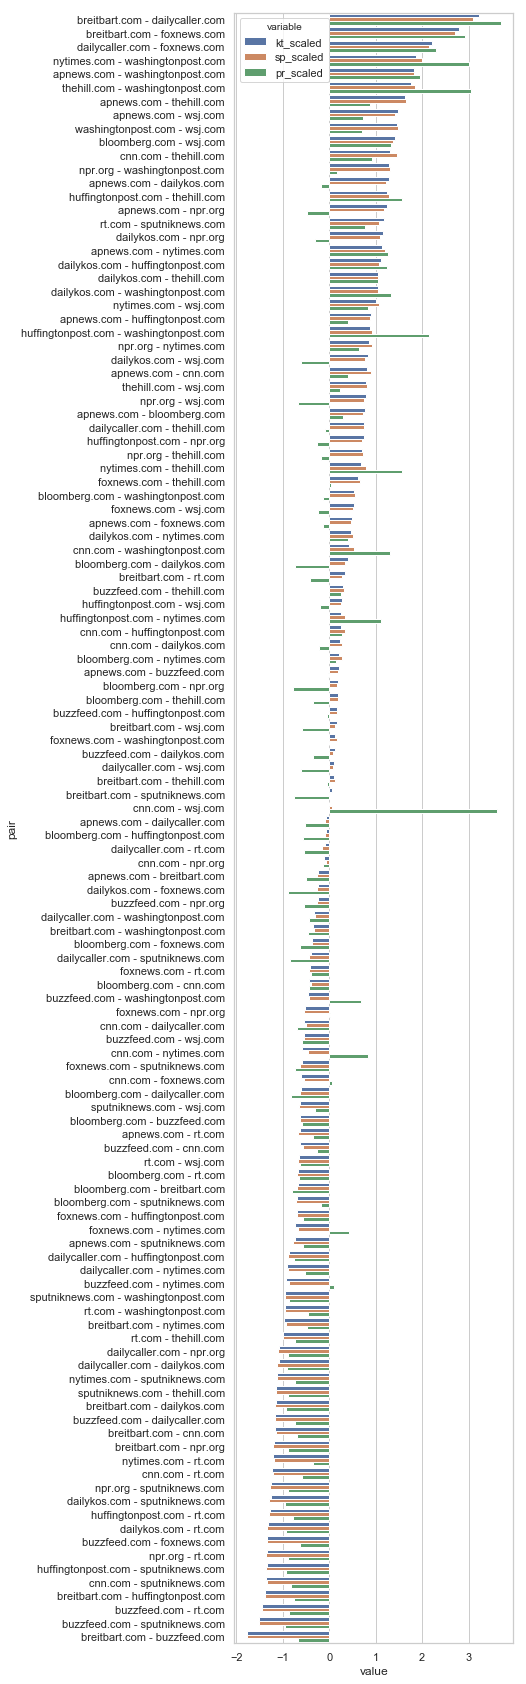

In [17]:
pdf = pd.melt(df, ['pair'], ['kt_scaled', 'sp_scaled', 'pr_scaled'])
order = pdf[pdf.variable=='kt_scaled'].sort_values('value', ascending=False).pair
plt.figure(figsize=(5,30))
sns.barplot(x='value', y='pair', data=pdf, hue='variable', order=order)

In [18]:
BINARIZED_DOMAIN_COUNTS = Counter()

for row in tqdm(ACTOR_DOMAIN_COUNTS):
    domains = [DOMAINS[i] for i, c in enumerate(row['counts']) if c > 0]
    BINARIZED_DOMAIN_COUNTS.update(domains)

100%|██████████| 8444480/8444480 [00:34<00:00, 242965.71it/s]


In [19]:
BINARIZED_DOMAIN_COUNTS = [BINARIZED_DOMAIN_COUNTS[d] for d in DOMAINS]

In [20]:
DOMAIN_COUNT_PRIOR = np.array(BINARIZED_DOMAIN_COUNTS) / sum(BINARIZED_DOMAIN_COUNTS)
DOMAIN_COUNT_PRIOR = torch.from_numpy(DOMAIN_COUNT_PRIOR).view(1, -1)

In [21]:
DOMAIN_COUNT_PRIOR

tensor([[0.1569, 0.0535, 0.0060, 0.1056, 0.0471, 0.1719, 0.0115, 0.0714, 0.0740,
         0.0558, 0.0402, 0.0246, 0.0200, 0.0950, 0.0259, 0.0408]],
       dtype=torch.float64)

In [22]:
OBSERVED_PAIR_COUNTS = Counter()

for row in tqdm(ACTOR_DOMAIN_COUNTS):
    
    domains = [DOMAINS[i] for i, c in enumerate(row['counts']) if c > 0]
    
    for d1, d2 in combinations(domains, 2):
        OBSERVED_PAIR_COUNTS[make_key(d1, d2)] += 1

100%|██████████| 8444480/8444480 [00:48<00:00, 175592.48it/s]


In [23]:
SAMPLED_PAIR_COUNTS = {pair: np.zeros(10, dtype='int') for pair in pairs}

ps = DOMAIN_COUNT_PRIOR.repeat(10, 1)

for row in tqdm(ACTOR_DOMAIN_COUNTS):
    
    num_domains = len([DOMAINS[i] for i, c in enumerate(row['counts']) if c > 0])
    
    # Sample N domains <-> N observed.
    sampled_idxs = torch.multinomial(ps, num_domains)
    
    for si, idxs in enumerate(sampled_idxs.tolist()):

        sampled_domains = [DOMAINS[i] for i in idxs]

        for d1, d2 in combinations(sampled_domains, 2):
            SAMPLED_PAIR_COUNTS[make_key(d1, d2)][si] += 1

100%|██████████| 8444480/8444480 [11:51<00:00, 11864.74it/s]


In [24]:
sum(OBSERVED_PAIR_COUNTS.values())

33079281

In [25]:
sum([s[0] for s in SAMPLED_PAIR_COUNTS.values()])

33079281

In [26]:
rows = []
for pair, oc in OBSERVED_PAIR_COUNTS.items():
    samples = SAMPLED_PAIR_COUNTS[pair]
    z = (oc - np.mean(samples)) / np.std(samples)
    rows.append((*pair, float(z)))

In [27]:
pc_df = pd.DataFrame(rows, columns=('d1', 'd2', 'pc'))
pc_df['pc_scaled'] = preprocessing.scale(pc_df['pc'])

In [28]:
df = df.merge(pc_df, on=('d1', 'd2'))

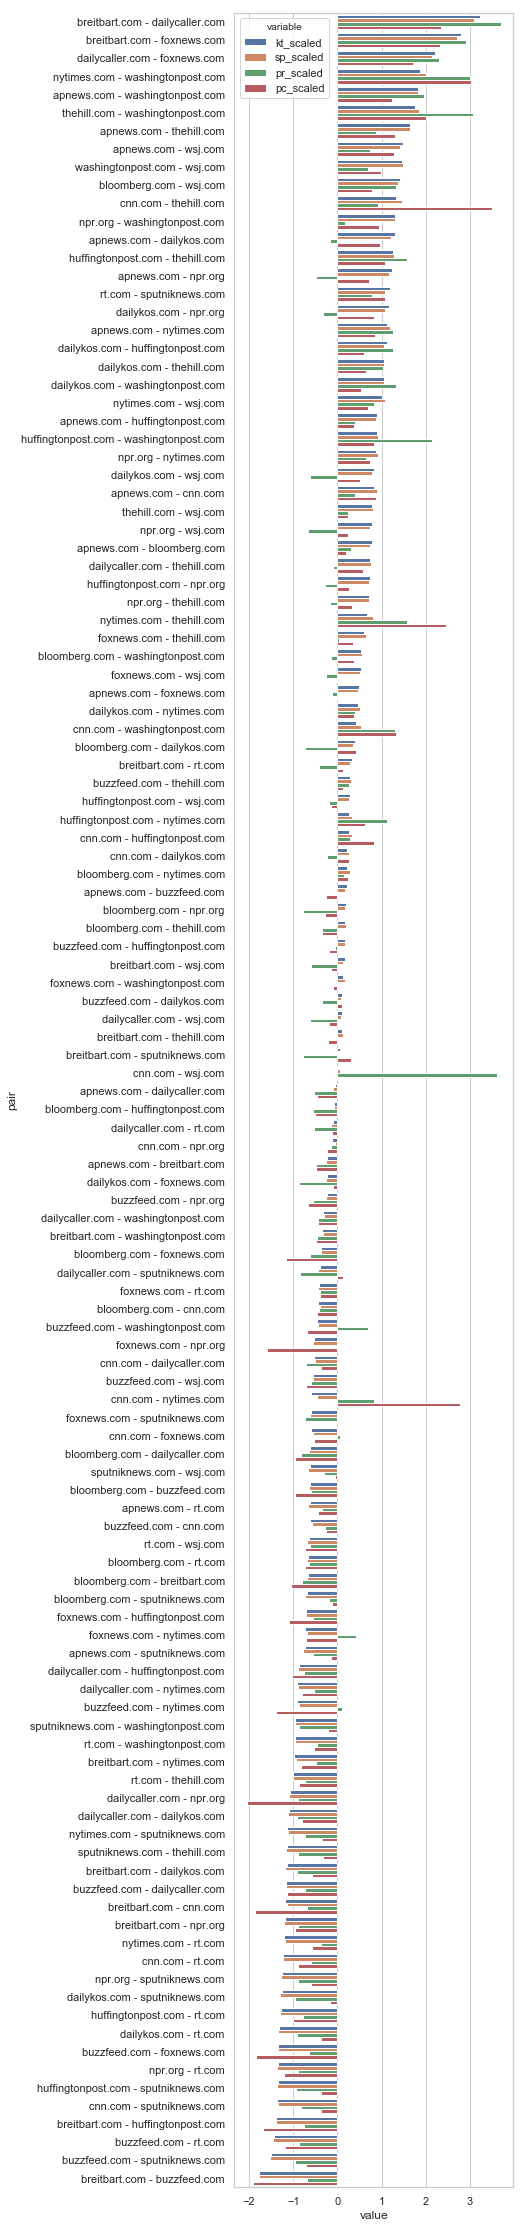

In [29]:
pdf = pd.melt(df, ['pair'], ['kt_scaled', 'sp_scaled', 'pr_scaled', 'pc_scaled'])
order = pdf[pdf.variable=='kt_scaled'].sort_values('value', ascending=False).pair
plt.figure(figsize=(5,40))
sns.barplot(x='value', y='pair', data=pdf, hue='variable', order=order)

In [30]:
for c1, c2 in combinations(['sp_scaled', 'kt_scaled', 'pr_scaled', 'pc_scaled'], 2):
    print(c1, c2, stats.kendalltau(df[c1], df[c2]))

sp_scaled kt_scaled KendalltauResult(correlation=0.9725490196078431, pvalue=6.796581075248128e-56)
sp_scaled pr_scaled KendalltauResult(correlation=0.6005602240896357, pvalue=2.33104748103975e-22)
sp_scaled pc_scaled KendalltauResult(correlation=0.6985994397759103, pvalue=1.1189126583161203e-29)
kt_scaled pr_scaled KendalltauResult(correlation=0.5831932773109243, pvalue=3.555619088874033e-21)
kt_scaled pc_scaled KendalltauResult(correlation=0.692436974789916, pvalue=3.473864793690418e-29)
pr_scaled pc_scaled KendalltauResult(correlation=0.5238095238095238, pvalue=2.190467095529766e-17)


In [32]:
df.to_json('data/audience-graph.json', orient='records', lines=True)